In [1]:
import tensorflow as tf
import numpy as np
from utils import *
from modules import dense_layer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [29]:
n_layers_gen=4
n_nodes_gen = 784

n_layers_dis=4
n_nodes_dis = 512

c = .001
n_critic = 5

lr = .00005
n_steps = 500

In [3]:
def Gen(z,reuse=None):
    """
    z : randoom noise tensor
    """
    with tf.variable_scope('Generator',reuse=reuse):
        x = z
        for i in range(n_layers_gen):
            x = dense_layer(x,n_nodes_gen,name_suffix='_%d'%i)
    return x

In [4]:
def Dis(x,reuse=None):
    """
    x : input tensor
    """
    with tf.variable_scope('Discriminator',reuse=reuse):
        for i in range(n_layers_dis):
            x = dense_layer(x,n_nodes_dis,name_suffix='_%d'%i)
        logits = dense_layer(x,1,name_suffix='_logit')
    return logits

In [5]:
def clip_dis(c,dis_vars):

    r = []
    for v in dis_vars:
        v_clipped=tf.clip_by_value(v,clip_value_min=-c,clip_value_max=c)
        r.append(tf.assign(v,v_clipped))
        
    return r

In [6]:
b = get_trainer()
x_feed,_=b.next_batch()

In [7]:
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(tf.float32,shape=[None,784])
    z = tf.placeholder(tf.float32,shape=[None,784])
    
    dis_real = Dis(x,reuse=None)
    gen = Gen(z)
    
    dis_fake = Dis(gen,reuse=True)
    
    dis_loss = -(tf.reduce_mean(dis_real) - tf.reduce_mean(dis_fake))
    gen_loss = -tf.reduce_mean(dis_fake)
    
    #Get variables
    train_vars = tf.get_collection('trainable_variables')
    dis_vars=[v for v in train_vars if 'Discriminator' in v.name]
    gen_vars=[v for v in train_vars if 'Generator' in v.name]
    
    opt_critic = tf.train.RMSPropOptimizer(lr).minimize(dis_loss,var_list=dis_vars)
    opt_gen = tf.train.RMSPropOptimizer(lr).minimize(gen_loss,var_list=gen_vars)
    
    #op to clip discriminator weights
    clip_discrim = clip_dis(c,dis_vars)
    
    init = tf.global_variables_initializer()

In [8]:
sess = tf.Session(graph = g)
sess.run(init)
losses = []

In [30]:
for _ in tqdm(range(n_steps)):
    for n in range(n_critic):
        sess.run([opt_critic],feed_dict={x : x_feed, z : np.random.uniform(low=-1,high=1,size=(32,784))})
        sess.run(clip_discrim)
    sess.run(opt_gen,feed_dict={z : np.random.uniform(low=-1,high=1,size=(32,784)) })
    l=sess.run(gen_loss,feed_dict={x : x_feed, z : np.random.uniform(low=-1,high=1,size=(32,784))})
    losses.append(l)

100%|██████████| 500/500 [00:53<00:00,  9.63it/s]


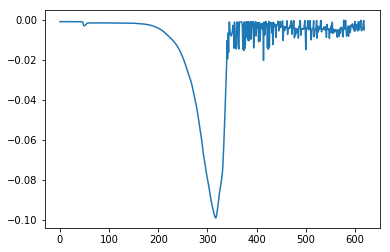

In [31]:
plt.plot(losses)

In [32]:
gen_images = sess.run(gen,feed_dict={z : np.random.uniform(low=-1,high=1,size=(32,784))})

In [17]:
def plot_images(images):
    fig = plt.subplots(911)
    for i in range(1,10):
        plt.subplot(91+i)
        plt.plot(np.reshape(images[i],(28,28)))

In [18]:
#plot_images(gen_images)

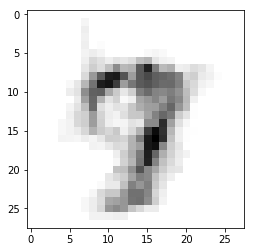

In [36]:
plt.imshow(np.reshape(gen_images[0],(28,28)),norm=None,cmap='Greys')